In [63]:
import pandas as pd
import re
import string
import time

# %pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop

from kerastuner import RandomSearch, HyperModel

import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing Functions

## Data cleaning: strip, lower, digit, punctuation

In [2]:
def basic_cleaning(text):
    """
    Clean the text data by removing whitespace, converting to lowercase, removing digits, punctuation, and HTML tags.
    Handles both Pandas Series and single string input.
    """
    if isinstance(text, pd.Series):
        text = text.str.strip()
        text = text.str.lower()
        text = text.apply(lambda x: ''.join(char for char in x if not char.isdigit()))
        text = text.str.replace(r'[{}]'.format(re.escape(string.punctuation)), '', regex=True)
        text = text.apply(lambda x: re.sub('<[^<]+?>', '', x))
    elif isinstance(text, str):
        text = text.strip()
        text = text.lower()
        text = ''.join(char for char in text if not char.isdigit())
        text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), '', text)
        text = re.sub('<[^<]+?>', '', text)
    else:
        text = ''
    return text


## Data cleaning: tokenizing, stopwords, lemmatize

In [3]:
stop_words = set(stopwords.words('english'))

# Tokenize and remove stop words
def delete_stop_words(text):
    if isinstance(text, list):
        return [word for word in text if word.lower() not in stop_words and word not in string.punctuation]
    else:
        return []

# Apply lemmatization function
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    if isinstance(text, list):
        # Lemmatize verbs
        verb_lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in text]
        # Lemmatize nouns
        return [lemmatizer.lemmatize(word, pos="n") for word in verb_lemmatized]
    else:
        return []

# NLP cleaning function
def nlp_cleaning(text):
    if isinstance(text, pd.Series):
        # Tokenization
        text = text.apply(word_tokenize)
        # Remove stop words
        text = text.apply(delete_stop_words)
        # Lemmatization
        text = text.apply(lemmatize_text)
        # Combine words into a string
        return text.apply(lambda x: ' '.join(x))
    elif isinstance(text, str):
        words = word_tokenize(text)
        words = delete_stop_words(words)
        words = lemmatize_text(words)
        return ' '.join(words)
    else:
        return ''


# RNN Model (Recurrent Neural Networks)

### Load and Preprocess Data

In [4]:
# Load the data
data = pd.read_csv('../data/WELFake_Dataset.csv')

In [5]:
# Fill missing values with spaces
data = data.fillna(' ')

# Verify that there are no missing values
print(data.isnull().sum())

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


In [6]:
# Combine 'title' and 'text' columns, then drop 'title' column
data['text'] = data['title'] + ' ' + data['text']
data.drop('title', axis=1, inplace=True)

# Verify the changes
print(data.head(2))

   Unnamed: 0                                               text  label
0           0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...      1
1           1     Did they post their votes for Hillary already?      1


In [7]:
# Apply basic cleaning to the 'text' column
data['text'] = basic_cleaning(data['text'])

# Verify the changes
print(data['text'].head(2))

0    law enforcement on high alert following threat...
1        did they post their votes for hillary already
Name: text, dtype: object


In [8]:
# Apply NLP cleaning to the 'text' column
data['text'] = nlp_cleaning(data['text'])

# Verify the changes
print(data['text'].head(2))

0    law enforcement high alert follow threat cop w...
1                            post vote hillary already
Name: text, dtype: object


In [9]:
# Check the shape of the DataFrame before and after removing duplicates
before = data.shape[0]
data.drop_duplicates(inplace=True)
after = data.shape[0]
print(f"Rows before: {before}, Rows after: {after}, Duplicates removed: {before - after}")

Rows before: 72134, Rows after: 72134, Duplicates removed: 0


In [ ]:
# Shuffle the dataframe to ensure randomness
data = data.sample(frac=1, random_state=42)

# Verify shuffling
print(data.head(2))

       Unnamed: 0                                               text  label
61370       61370  arnold schwarzenegger send message liberal whi...      1
2189         2189  wow “ mexican need kill donald trump become pr...      1


In [ ]:
# Separate the features (text) and labels (label) into X and y
X = data['text']
y = data['label']

# Verify the separation
print(X.head(2))
print(y.head(2))

61370    arnold schwarzenegger send message liberal whi...
2189     wow “ mexican need kill donald trump become pr...
Name: text, dtype: object
61370    1
2189     1
Name: label, dtype: int64


### Tokenize and Pad Sequences

In [12]:
# Word count for each entry in the 'text' column
data['word_count'] = data['text'].apply(lambda x: len(x.split()))
data['word_count'].describe()

count    72134.000000
mean       324.460712
std        363.685469
min          1.000000
25%        142.000000
50%        240.000000
75%        399.000000
max      20915.000000
Name: word_count, dtype: float64

In [13]:
# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to ensure uniform input length
X_padded = pad_sequences(X_seq, maxlen=500)

In [14]:
# Verify the tokenized and padded sequences
print(X_padded[:5])

[[   0    0    0 ... 3481    5  100]
 [   0    0    0 ...   69 1067  378]
 [   0    0    0 ...  535 1231 3378]
 [   0    0    0 ...   36 2650   17]
 [   0    0    0 ...   37  250 1430]]


### Train-Test Split

In [ ]:
# Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42)

# Verify the shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (50493, 500), X_test shape: (21641, 500)
y_train shape: (50493,), y_test shape: (21641,)


### Tuning Simple RNN Model 1

In [62]:
# Instantiate the model
rnn_model_1 = Sequential()

# Add an embedding layer
rnn_model_1.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_1.add(SimpleRNN(units=128, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_1.add(Dropout(rate=0.5))

# Add another dense layer and dropout layer
rnn_model_1.add(Dense(units=64, activation='relu'))
rnn_model_1.add(Dropout(rate=0.5))

# Add the final dense output layer with sigmoid activation
rnn_model_1.add(Dense(units=1, activation='sigmoid'))


In [ ]:
# Adjust the Adam optimizer parameters
adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile the model
rnn_model_1.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Train the Model

In [ ]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history_1 = rnn_model_1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 135s 171ms/step - accuracy: 0.8728 - loss: 0.3059 - val_accuracy: 0.7962 - val_loss: 0.4215
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 137s 174ms/step - accuracy: 0.7946 - loss: 0.4379 - val_accuracy: 0.8403 - val_loss: 0.3544
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 133s 169ms/step - accuracy: 0.8618 - loss: 0.3243 - val_accuracy: 0.8857 - val_loss: 0.2915
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 130s 165ms/step - accuracy: 0.8932 - loss: 0.2729 - val_accuracy: 0.8893 - val_loss: 0.2834
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 131s 166ms/step - accuracy: 0.8814 - loss: 0.2911 - val_accuracy: 0.8967 - val_loss: 0.2666
Epoch 6/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 114s 144ms/step - accuracy: 0.9026 - loss: 0.2566 - val_accuracy: 0.7960 - val_loss: 0.4169
Epoch 7/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 126s 160ms/step - accuracy: 0.7981 - loss: 0.4258 - val_accuracy: 0.7981 - val_loss: 0.4118
Epoch 8/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 136s 172ms/step - accuracy: 0.8048 -

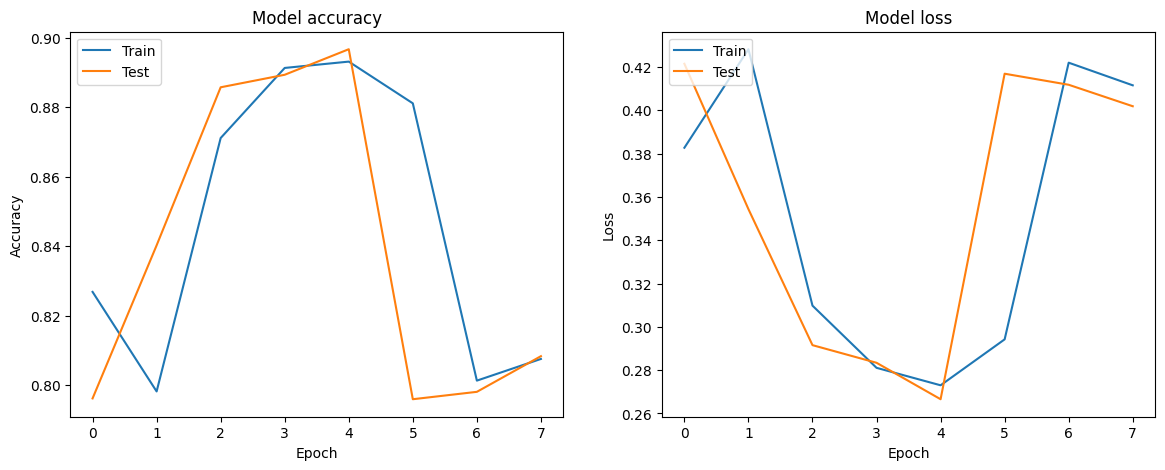

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Evaluate the Model

In [ ]:
# Evaluate the model on the test data
loss_1, accuracy_1 = rnn_model_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_1:.2f}")

677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.8978 - loss: 0.2625
Test Accuracy: 0.90


Predict

In [ ]:
# Generate predictions
y_pred_prob_1 = rnn_model_1.predict(X_test)
# Convert probabs to 0 or 1
y_pred_1 = (y_pred_prob_1 > 0.5).astype(int)

677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step


In [ ]:
# Performance metrics
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1)
recall_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)

# Print performance metrics
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_1))


Accuracy: 0.90
Precision: 0.91
Recall: 0.88
F1 Score: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.91      0.89     10442
           1       0.91      0.88      0.90     11199

    accuracy                           0.90     21641
   macro avg       0.90      0.90      0.90     21641
weighted avg       0.90      0.90      0.90     21641



In [ ]:
# Calculate the confusion matrix
cm_1 = confusion_matrix(y_test, y_pred_1)

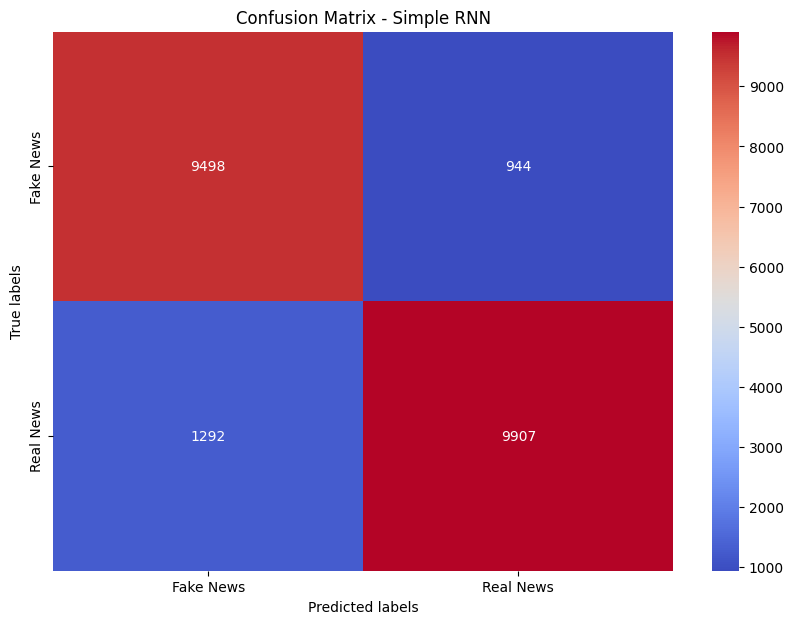

In [ ]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_1, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Simple RNN')

# Set custom tick labels
ax.xaxis.set_ticklabels(['Fake News', 'Real News'])
ax.yaxis.set_ticklabels(['Fake News', 'Real News'])

# Show the plot
plt.show()


Analysis

Analysis:
	- The model correctly recognized 9498 ‘fake news’ items and correctly classified 9907 ‘real news’ items.
	- However, it made 944 errors by classifying ‘fake news’ as ‘real news’.
	- 1292 ‘real news’ was incorrectly classified as ‘fake news’.

Interpretation:

The number of false positives (1292) and false negatives (944) indicates that the model has room for improvement in reliably distinguishing ‘fake news’ from ‘real news’.

In [61]:
rnn_model_1.save('trained_rnn_model_1.h5') # save in h5 compressed format

### Tuning Simple RNN Model 2

In [64]:
# Instantiate the model
rnn_model_2 = Sequential()

# Add an embedding layer
rnn_model_2.add(Embedding(input_dim=5000, output_dim=128))

# Add a simple RNN layer with 128 units
rnn_model_2.add(SimpleRNN(units=32, return_sequences=False))

# Add dropout layers to prevent overfitting
rnn_model_2.add(Dropout(rate=0.1))

# Add another dense layer and dropout layer
rnn_model_2.add(Dense(units=64, activation='relu'))
rnn_model_2.add(Dropout(rate=0.1))

# Add the final dense output layer with sigmoid activation
rnn_model_2.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Adjust the Adam optimizer parameters
optimizer = RMSprop()

# Compile the model
rnn_model_2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

Train the Model

In [66]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and model checkpoint
history_2 = rnn_model_2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 174s 208ms/step - accuracy: 0.8715 - loss: 0.3070 - val_accuracy: 0.9290 - val_loss: 0.1731
Epoch 2/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 164s 208ms/step - accuracy: 0.9437 - loss: 0.1478 - val_accuracy: 0.9468 - val_loss: 0.1406
Epoch 3/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 173s 219ms/step - accuracy: 0.9647 - loss: 0.1022 - val_accuracy: 0.9506 - val_loss: 0.1449
Epoch 4/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 171s 219ms/step - accuracy: 0.9768 - loss: 0.0681 - val_accuracy: 0.9465 - val_loss: 0.1520
Epoch 5/10
789/789 ━━━━━━━━━━━━━━━━━━━━ 170s 215ms/step - accuracy: 0.9836 - loss: 0.0495 - val_accuracy: 0.9439 - val_loss: 0.2185


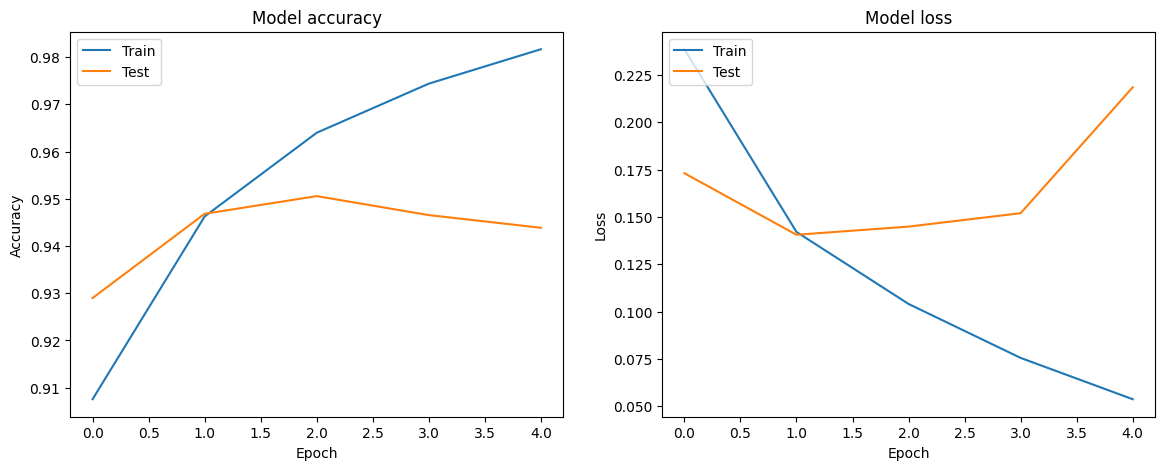

In [67]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Evaluate the Model

In [69]:
# Evaluate the model on the test data
loss_2, accuracy_2 = rnn_model_2.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy_2:.2f}")

677/677 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step - accuracy: 0.9475 - loss: 0.1345
Test Accuracy: 0.95


Predict

In [70]:
# Generate predictions
y_pred_prob_2 = rnn_model_2.predict(X_test)
# Convert probabs to 0 or 1
y_pred_2 = (y_pred_prob_2 > 0.5).astype(int)

677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 47ms/step


In [71]:
# Performance metrics
perfomance_accuracy_2 = accuracy_score(y_test, y_pred_2)
perfomance_precision_2 = precision_score(y_test, y_pred_2)
perfomance_recall_2 = recall_score(y_test, y_pred_2)
perfomance_f1_2 = f1_score(y_test, y_pred_2)

# Print performance metrics
print(f"Accuracy: {perfomance_accuracy_2:.2f}")
print(f"Precision: {perfomance_precision_2:.2f}")
print(f"Recall: {perfomance_recall_2:.2f}")
print(f"F1 Score: {perfomance_f1_2:.2f}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_2))


Accuracy: 0.95
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10442
           1       0.95      0.95      0.95     11199

    accuracy                           0.95     21641
   macro avg       0.95      0.95      0.95     21641
weighted avg       0.95      0.95      0.95     21641



In [72]:
# Calculate the confusion matrix
cm_2 = confusion_matrix(y_test, y_pred_2)

In [83]:
cm_2

array([[ 9867,   575],
       [  576, 10623]])

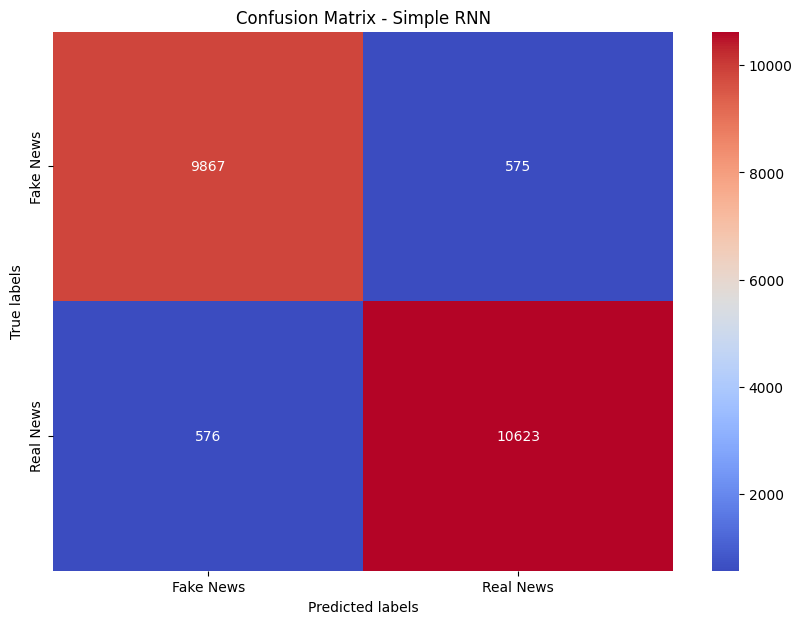

In [73]:
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_2, annot=True, fmt="d", cmap="coolwarm", cbar=True)

# Set axis labels and title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Simple RNN')

# Set custom tick labels
ax.xaxis.set_ticklabels(['Fake News', 'Real News'])
ax.yaxis.set_ticklabels(['Fake News', 'Real News'])

# Show the plot
plt.show()


Analysis

Analysis:
	- The model correctly recognized 9867 ‘fake news’ items and correctly classified 10623 ‘real news’ items.
	- However, it made 575 errors by classifying ‘fake news’ as ‘real news’.
	- 576 ‘real news’ was incorrectly classified as ‘fake news’.

Interpretation:

The reduction in number of false positives (576) and false negatives (575) indicates that the model tunning has resulted in an accurate predicyion model, with and accuracy of 95%.

In [74]:
rnn_model_2.save('trained_rnn_model_2.h5') # save in h5 compressed format

## Loading saved model and testing

In [85]:
trained_rnn_model_2_h5 = tf.keras.models.load_model('trained_rnn_model_2.h5')

In [86]:
trained_rnn_model_2_h5.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 500, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,331 (2.47 MB)

 Trainable params: 647,329 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [87]:
# The article text
article_text = "A Fargo, North Dakota, man was arrested for clearing snow with a flamethrower."


In [88]:
# Preprocess the text (same steps as during training)
article_cleaned = basic_cleaning(article_text)
article_nlp = nlp_cleaning(pd.DataFrame([article_cleaned]))

In [89]:
# Tokenize and pad the sequence
article_seq = tokenizer.texts_to_sequences(article_nlp[0])
article_padded = pad_sequences(article_seq, maxlen=500)

IndexError: string index out of range

In [84]:
# Predict the probability
prediction_prob = trained_rnn_model_2_h5.predict(article_padded)


/home/jarrod/.pyenv/versions/Fake_news_detection/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

In [ ]:

# Convert probability to binary prediction (0 or 1)
prediction = (prediction_prob > 0.5).astype(int)

# Interpret the prediction
if prediction[0][0] == 1:
    result = "Fake News"
else:
    result = "Real News"

print(f"Prediction: {result}")


## Hyperparameter tuning function

In [ ]:
# Define the hypermodel class
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=5000, output_dim=128))
        model.add(SimpleRNN(units=hp.Int('units', min_value=32, max_value=256, step=32)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(
            optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model


In [52]:

# Initialize the tuner
tuner = RandomSearch(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='hyperparam_tuning',
    project_name='fake_news_detection'
)


In [53]:

# Perform the search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best units: {best_hp.get('units')}")
print(f"Best dropout: {best_hp.get('dropout')}")
print(f"Best optimizer: {best_hp.get('optimizer')}")


Trial 5 Complete [01h 43m 13s]
val_accuracy: 0.9450733860333761

Best val_accuracy So Far: 0.9502949714660645
Total elapsed time: 08h 35m 19s
Best units: 32
Best dropout: 0.1
Best optimizer: rmsprop


In [54]:

# Build and train the best model
best_model = tuner.hypermodel.build(best_hp)


In [56]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,660 (4.94 MB)

 Trainable params: 647,329 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 647,331 (2.47 MB)

In [55]:
best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 200s 124ms/step - accuracy: 0.8736 - loss: 0.3007 - val_accuracy: 0.9445 - val_loss: 0.1554
Epoch 2/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 198s 126ms/step - accuracy: 0.9494 - loss: 0.1404 - val_accuracy: 0.9392 - val_loss: 0.1615
Epoch 3/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 199s 126ms/step - accuracy: 0.9596 - loss: 0.1179 - val_accuracy: 0.9557 - val_loss: 0.1420
Epoch 4/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 200s 126ms/step - accuracy: 0.9669 - loss: 0.0967 - val_accuracy: 0.9419 - val_loss: 0.1896
Epoch 5/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 197s 125ms/step - accuracy: 0.9728 - loss: 0.0804 - val_accuracy: 0.9179 - val_loss: 0.2325
Epoch 6/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 198s 125ms/step - accuracy: 0.9803 - loss: 0.0611 - val_accuracy: 0.9338 - val_loss: 0.2053
Epoch 7/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 200s 127ms/step - accuracy: 0.9857 - loss: 0.0465 - val_accuracy: 0.9399 - val_loss: 0.1975
Epoch 8/10
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 199s 126ms/step - ac